Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Cities that hosted Olympics:
 City
Montreal       1
Moscow         1
Los Angeles    1
Seoul          1
Barcelona      1
Atlanta        1
Sydney         1
Athens         1
Beijing        1
Name: count, dtype: int64


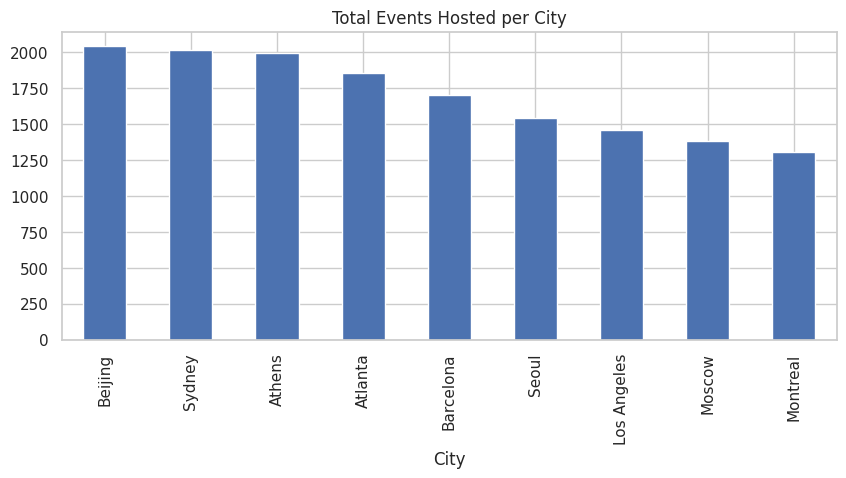

Total unique events: 334


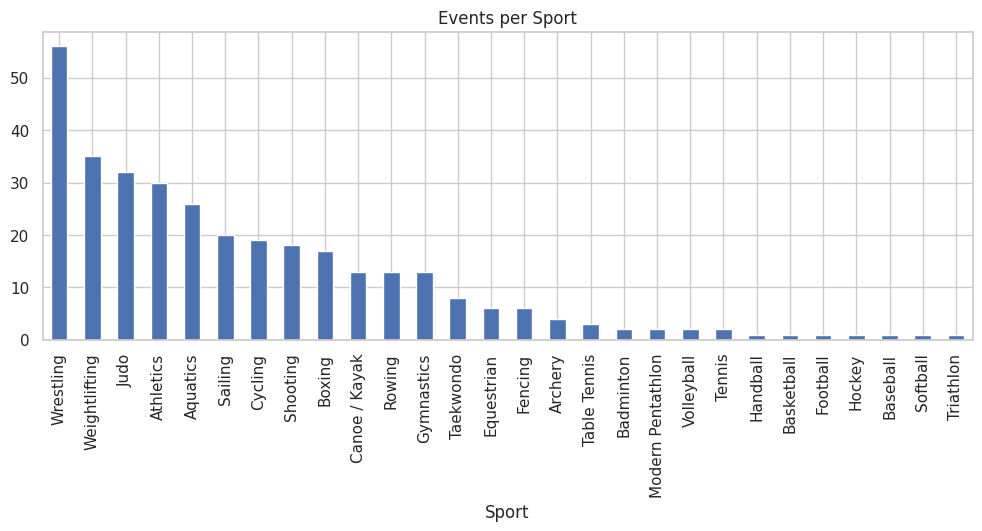

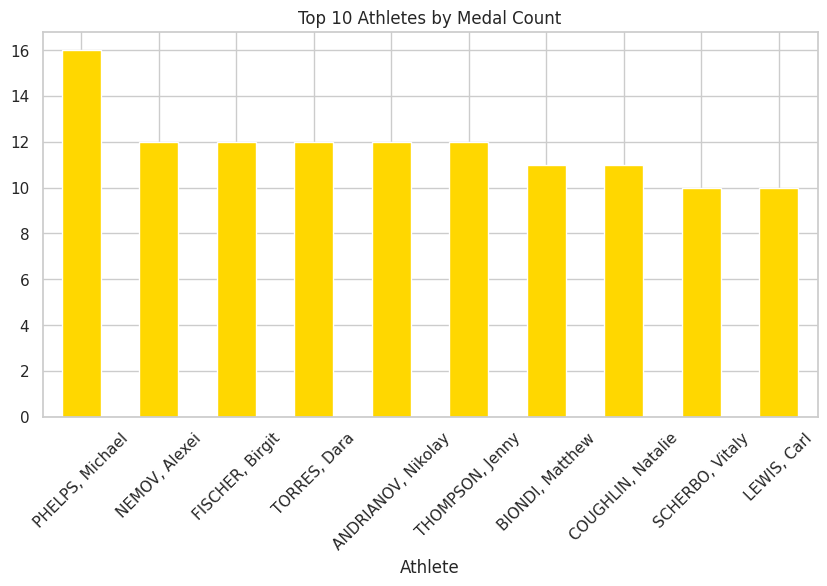

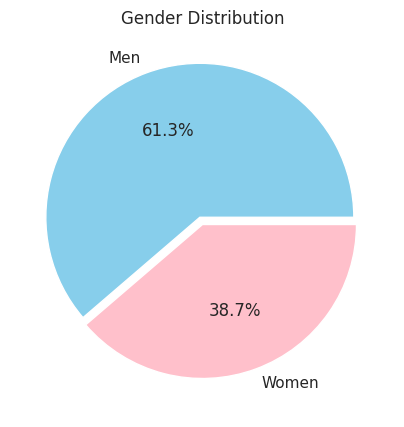

Top 5 rows of country medal pivot:
 Medal  Year        Country  Bronze   Gold  Silver  Total
30     1976   Soviet Union    79.0  113.0    93.0  285.0
10     1976   East Germany    42.0   99.0    51.0  192.0
37     1976  United States    36.0   63.0    56.0  155.0
39     1976   West Germany    30.0   21.0    24.0   75.0
26     1976         Poland    26.0   18.0    29.0   73.0
Top country per sport:
          Sport        Country  Count
43    Aquatics  United States    578
56     Archery   Korea, South     52
142  Athletics  United States    299
145  Badminton          China     47
153   Baseball           Cuba    111
Athletes who medaled in multiple sports:
 Athlete
BELOVA, Irina           2
CHEN, Jing              2
DIMITROV, Stefan        2
GAVRILOV, Yuri          2
GONZALEZ, Raul          2
KOLESNIKOV, Nikolai     2
KOVACS, Istvan          2
KOVALENKO, Alexandre    2
KUZNETSOV, Mikhail      2
KUZNETSOV, Nikolai      2
LEE, Eun Kyung          2
LI, Na                  2
LI, Ting      

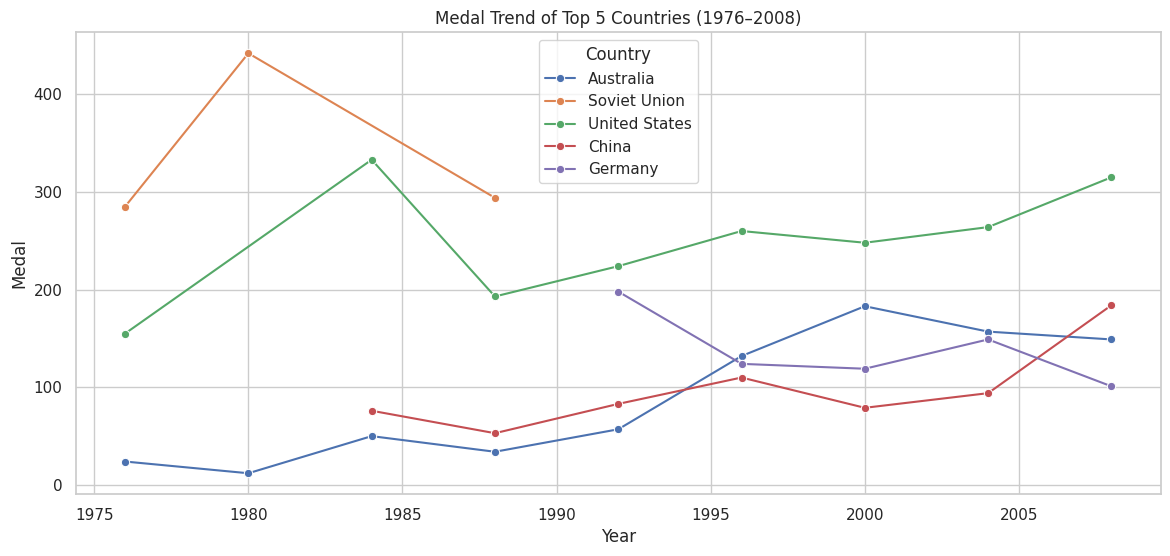

🎯 Logistic Regression Results
Accuracy: 0.9421859039836568
Confusion Matrix:
 [[   0  283]
 [   0 4612]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       283
           1       0.94      1.00      0.97      4612

    accuracy                           0.94      4895
   macro avg       0.47      0.50      0.49      4895
weighted avg       0.89      0.94      0.91      4895



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [14]:
from google.colab import drive
drive.mount('/content/drive')

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Load & Clean Data
df = pd.read_csv('/content/Summer-Olympic-medals-1976-to-2008.csv', encoding='latin1')
df.drop(['Event_gender', 'Country_Code'], axis=1, inplace=True)
df.dropna(how='all', inplace=True)
df = df.astype({'Year': int})
df.dropna(inplace=True)

# Q1: Cities that hosted Olympics
print("Cities that hosted Olympics:\n", df[['City', 'Year']].drop_duplicates()['City'].value_counts())

# Q2: City with Most Events
plt.figure(figsize=(10,4))
df['City'].value_counts().plot(kind='bar')
plt.title('Total Events Hosted per City')
plt.show()

# Q3: Unique Events & Sports
unique_events = df[['Sport', 'Discipline', 'Event']].drop_duplicates()
print("Total unique events:", len(unique_events))
plt.figure(figsize=(12,4))
unique_events['Sport'].value_counts().plot(kind='bar')
plt.title('Events per Sport')
plt.show()

# Q4: Top 10 Athletes by Medals
top_athletes = df['Athlete'].value_counts().head(10)
plt.figure(figsize=(10,5))
top_athletes.plot(kind='bar', color='gold')
plt.title('Top 10 Athletes by Medal Count')
plt.xticks(rotation=45)
plt.show()

# Q5: Gender Distribution
gender_counts = df['Gender'].value_counts()
plt.figure(figsize=(5,5))
gender_counts.plot(kind='pie', autopct='%1.1f%%', labels=['Men', 'Women'], colors=['skyblue','pink'], explode=[0.05, 0])
plt.title('Gender Distribution')
plt.ylabel('')
plt.show()

# Q6: Country-wise Medal Count by Year
grouped = df.groupby(['Year', 'Country', 'Medal']).size().reset_index(name='Count')
pivot = grouped.pivot_table(index=['Year','Country'], columns='Medal', values='Count', fill_value=0)
pivot['Total'] = pivot.sum(axis=1)
pivot = pivot.reset_index().sort_values(['Year','Total'], ascending=[True,False])
print("Top 5 rows of country medal pivot:\n", pivot.head())

# Q7: Top Country per Sport
dom = df.groupby(['Sport','Country']).size().reset_index(name='Count')
top_per_sport = dom.sort_values(['Sport','Count'], ascending=[True,False]).groupby('Sport').head(1)
print("Top country per sport:\n", top_per_sport.head())

# Q8: Multi-sport medalists
ath_sport = df[['Athlete','Sport']].drop_duplicates()
multi = ath_sport.groupby('Athlete')['Sport'].nunique()
multi_sport_athletes = multi[multi > 1]
print("Athletes who medaled in multiple sports:\n", multi_sport_athletes)

# Q9: Medal Trend of Top 5 Countries
medals = df.groupby(['Year','Country'])['Medal'].count().reset_index()
top_countries = medals.groupby('Country')['Medal'].sum().sort_values(ascending=False).head(5).index
filtered = medals[medals['Country'].isin(top_countries)]
plt.figure(figsize=(14,6))
sns.lineplot(data=filtered, x='Year', y='Medal', hue='Country', marker='o')
plt.title('Medal Trend of Top 5 Countries (1976–2008)')
plt.grid(True)
plt.show()

# ✅ ML Model (Fixed): Predict whether an athlete wins a medal

# Step 1: Add binary label
df['Won_Medal'] = 1

# Step 2: Simulate non-winners (create 1000 negative samples)
non_winners = df.sample(1000, random_state=42).copy()
non_winners['Won_Medal'] = 0
non_winners['Medal'] = np.nan  # Just to make it clear

# Step 3: Combine both datasets
df_ml = pd.concat([df, non_winners], ignore_index=True)

# Step 4: Encode features
le = LabelEncoder()
for col in ['Country', 'Sport', 'Gender', 'Discipline']:
    df_ml[col] = le.fit_transform(df_ml[col])

# Step 5: Prepare feature matrix and target
X = df_ml[['Country', 'Sport', 'Gender', 'Discipline']]
y = df_ml['Won_Medal']

# Step 6: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 7: Train Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Step 8: Evaluate
print("Logistic Regression Results")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))